Bengio's idea: "we might have sentence "dog is walking" during training, but not "cat was sleeping" so with n-grams 2nd gets zero probability bengio says those are similar , so also should get high probs thats why we describe words or tokens as continuos vectors in embeddings, and close words will be located closer in vector space"


model:


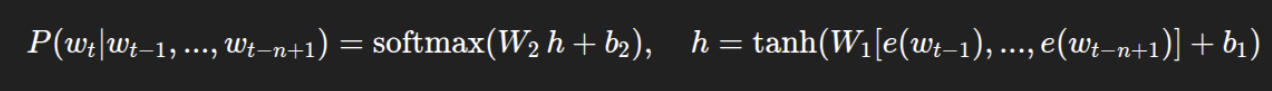
<br>
e m m a<br>
e(embeddings) + m(embeddings) + m(embeddings) -> a(embeddings)<br>
concatenate embeddings -> keeps positional information -> first linear layer learns weights for each position in the context<br>
if not concatenate but sum or avg -> "cat" identical "tac"<br>


2. dataset prep

stoi → string to index (encoder)
itos → index to string (decoder)

X: (N, 3)
Y: (N,)  # 1-D tensor

In [41]:
import urllib
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# load dataset
url = "https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt"
data = urllib.request.urlopen(url).read().decode("utf-8").splitlines()
data[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
# vocabulary
chars = sorted(list(set(''.join(data))))
chars = ['.'] + chars 
stoi = {ch: i for i, ch in enumerate(chars)}  # encoder
itos = {i: ch for ch, i in stoi.items()}  # decoder

In [11]:
# vocabulary size
len(chars)

27

In [9]:
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [10]:
itos

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [22]:
# build dataset
def build_dataset(names: list[str], context_len: int = 3) -> tuple[list[int], list[int]]:
    X, Y = [], []
    for name in names:
        s = '.' * context_len + name + '.'  # ...emma.
        for i in range(context_len, len(s)):
            context = s[i - context_len:i]
            target = s[i]
            X.append([stoi[c] for c in context])
            Y.append(stoi[target])
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y

X, Y = build_dataset(data, 3)
print(f"X.shape: {X.shape}\nY.shape: {Y.shape}")
print(f"\nX1 is {X[1]} and Y1 is {Y[1]}")

X.shape: torch.Size([228146, 3])
Y.shape: torch.Size([228146])

X1 is tensor([0, 0, 5]) and Y1 is 13


Embeddings: 1 vector per character<br>
Weights for 1st Linear layer(Wx, bh): maps concatenated embeddings to hidden layer <br>
Weights for Output layer(Why, by): maps hidden activations to logits for each vocab token

In [25]:
# embedding matrix
torch.manual_seed(42)
vocab_size = len(stoi)
embed_dim = 20

E = torch.randn(vocab_size, embed_dim) * 0.01  # random embedding matrix
print(E[1])
E.shape 


tensor([-0.0076,  0.0108,  0.0080,  0.0168,  0.0128,  0.0130,  0.0061,  0.0133,
        -0.0023,  0.0004, -0.0025,  0.0086, -0.0138, -0.0087, -0.0022,  0.0172,
         0.0032, -0.0042,  0.0031, -0.0077])


torch.Size([27, 20])

1st linear layer: concatenate embeddings and compute hidden activations<br>

divide by `sqrt(num_input_connections)` to fix vanishing and exploding gradients problem<br>
-> variance of activations constant from layer to layer


In [30]:
# 1st linear layer
hidden_size = 100
context_size = 3

Wx = torch.randn(hidden_size, context_size * embed_dim) / ((context_size * embed_dim) ** 0.5)
bh = torch.zeros(hidden_size)
Wy = torch.randn(vocab_size, hidden_size) / ((hidden_size) ** 0.5)  # output layer
by = torch.zeros(vocab_size)

print(Wx.shape, bh.shape, Wy.shape)

torch.Size([100, 60]) torch.Size([100]) torch.Size([27, 100])


`F.cross_entropy(logits, Y) = -log(softmax(logits)[range(N), Y])`

`training loop`:<br>
- Do the forward pass
- Compute loss
- Zero grads
- Backward pass
- Update parameters

In [37]:
epoches = 500

params = [E, Wx, bh, Wy, by]  # trainable parameters
for p in params:
    p.requires_grad = True

# training loop
for step in range(epoches):
    # forward pass
    emb = E[X] # (N, 3, 20) 
    emb_cat = emb.view(X.shape[0], -1)  # (N, 60)
    h = torch.tanh(emb_cat @ Wx.T + bh) # (N, 100)

    logits = h @ Wy.T + by  # (N, 27)
    loss = F.cross_entropy(logits, Y)

    # backward 
    for p in params:
        p.grad = None
    loss.backward()  

    # update (SGD)
    lr = 0.1
    for p in params:
        p.data -= lr * p.grad    
     
    if step % 20 == 0:
        print(f"step {step}: loss = {loss.item():.4f}")
    

step 0: loss = 2.6792
step 20: loss = 2.6626
step 40: loss = 2.6476
step 60: loss = 2.6340
step 80: loss = 2.6213
step 100: loss = 2.6094
step 120: loss = 2.5981
step 140: loss = 2.5874
step 160: loss = 2.5773
step 180: loss = 2.5677
step 200: loss = 2.5587
step 220: loss = 2.5502
step 240: loss = 2.5421
step 260: loss = 2.5346
step 280: loss = 2.5274
step 300: loss = 2.5206
step 320: loss = 2.5141
step 340: loss = 2.5079
step 360: loss = 2.5020
step 380: loss = 2.4964
step 400: loss = 2.4909
step 420: loss = 2.4857
step 440: loss = 2.4807
step 460: loss = 2.4759
step 480: loss = 2.4712


In [40]:
# inference
def generate_name():
    out = []
    context = [0, 0, 0]

    while True:
        # forward one step
        x = torch.tensor(context, dtype=torch.long)
        emb = E[x]  # (1, 3, 20)
        emb_cat = emb.view(1, -1)  # (1, 60)
        h = torch.tanh(emb_cat @ Wx.T + bh)  # (1, 100)
        logits = h @ Wy.T + by  # (1, 27)
        probs = F.softmax(logits, dim=1)

        # sample next char
        ix = torch.multinomial(probs, num_samples=1).item()

        # stop if '.' (end of name)
        if ix == 0:
            break

        out.append(ix)

        # update context
        context = context[1:] + [ix]

    return ''.join(itos[i] for i in out)

for _ in range(10):
    print(generate_name())


        
    

khhee
alhaza
niiade
ela
asee
labrir
vysh
sayan
jzherisdmanno
kari
